## **Installing Packages**

In [ ]:
!pip install textblob
!pip install sentencepiece  
!pip install transformers
!pip install textstat
!pip install language-tool-python
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 21.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 67.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https:/

Restart Runtime after installing 

## **Importing Packages**

In [ ]:
import re
import nltk 
import spacy
import textstat
import numpy as np
import pandas as pd
import seaborn as sn 
from textblob import Word
import matplotlib.pyplot as plt
import language_tool_python

from google.colab import files
from nltk.tag import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from sentence_transformers import SentenceTransformer, util
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")
tool = language_tool_python.LanguageTool('en-US')

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
INFO:language_tool_python.download_lt:Unzipping /tmp/tmpqdesyy68.zip to /root/.cache/language_tool_python.
INFO:language_tool_python.download_lt:Downloaded https://www.languagetool.org/download/LanguageTool-5.7.zip to /root/.cache/language_tool_python.


# **Reading Data From Google Drive**

For Training Material

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
Data_Essay_01 = pd.read_csv("/content/drive/MyDrive/IntelliTech-DataSet/EssaySet06.csv")
Data_Essay_01.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,ID,Essay,Rater_1 Score,Rater_2 Score,Total Score
0,14834,There were many obstacles that the builders fa...,2.0,2.0,2.0
1,14835,"Him from the start, there would have been many...",3.0,3.0,3.0
2,14836,The builders of the Empire State Building face...,3.0,4.0,4.0
3,14837,In the passage The Mooring Mast by Marcia Amid...,1.0,1.0,1.0
4,14838,The builders of the Empire State Building face...,3.0,3.0,3.0


For Testing Material

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
Data_Essay_01 = pd.read_excel("/content/drive/MyDrive/IntelliTech-DataSet/Testing Material/valid_set.xlsx")
Data_Essay_01 = Data_Essay_01.query('essay_set == 5')
Data_Essay_01.rename(columns = {'essay':'Essay'}, inplace = True)

Data_Essay_01.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,essay_id,essay_set,Essay,domain1_predictionid,domain2_predictionid
2343,13632.0,5.0,"The mood in ""@PERSON1"" by @PERSON1 is loving a...",16632.0,NaN
2344,13633.0,5.0,In the memoir Narciso Rodriguez by Narciso Rod...,16633.0,NaN
2345,13634.0,5.0,"In the memoir Narciso Rodriguez, Narciso tells...",16634.0,NaN
2346,13635.0,5.0,The mood of the story is that of the comforts ...,16635.0,NaN
2347,13636.0,5.0,"In the memoir Narciso Rodriguez, it explains t...",16636.0,NaN


# **Feature Extraction**

## **Essay Pre Processing**

In [ ]:
def Remove_NER(Essay):
  """
    Removes Named Entity Recognition (NER) from each essay

    Args:
      Sentence: Essay of each student 
    
    Returns: 
      String

  """
  token = Essay.split()
  newTokens = []
  # print(token)
  for i in range(len(token)):
    if "@" in token[i]:
      if "," in token[i]:
        newTokens.append(",")
      elif "." in token[i]:
        newTokens.append(".")
      elif "!" in token[i]:
        newTokens.append("!")
    else:
      newTokens.append(token[i])

  return " ".join(newTokens)
  # return ' '.join (word for word in Essay.split(' ') if not word.startswith('@'))
def Remove_NER2(Essay):
    return ' '.join (word for word in Essay.split(' ') if not word.startswith('@'))
def Remove_Punctuations(sentence):
  """
    Removes punctuations from text
    Args:
      sentence: Essay of each student
    
    Returns: 
      String
  """
  punctuations = '''!()-[]{};:"\,/'<>.?@#$%^&*_~'''
  newSentence = ""
  for word in sentence:
      if (word in punctuations):
          newSentence = newSentence + " "
      else: 
          newSentence = newSentence + word
  return newSentence

def LowerCase_Words(Essay):
  """
    Lower case all the words in an essay

    Args:
      Sentence: Essay of each student
    
    Returns: 
      String
  """
  return re.sub('[0-9]+','', Essay).lower() 

def Tokenize_Essay(Essay):
    """
      Create Tokens of each Essay

      Args:
        Essay: Essay of each student
      
      Returns: 
        String
    """
    Preprocessed = Remove_Punctuations(Essay)
    return " ".join(word_tokenize(Preprocessed))

def Remove_White_Spaces(Essay):
  """
    Removes Extra White Spaces

    Args:
      Essay: Essay of each student
    
    Returns: 
      String
  """
  return " ".join(Essay.split())

def Remove_Special_Characters(Essay):
  """
    Removes Special Characters from Essay

    Args:
      Essay: Essay of each student
    
    Returns: 
      String
  """
  new_text = re.sub(r"[^a-zA-Z0-9 ]", "", Essay)
  return new_text

## **Basic Count Features**

This section will cover:


*   Counting Sentences per Essay
*   Counting Words per Essay
*   Counting Characters per Essay
*   Average Words per Essay
*   Counting Syllables
*   Percentage Of Hard Words




#### Counting Sentences per Essay

In [ ]:
def Sentence_Count(Essay):
    """
    Counts sentences in an essay

    Args:
      Essay: Essay of each student 
    
    Returns: 
      int
  """
    sentence_no = nltk.sent_tokenize(Essay)
    return len(sentence_no)

In [ ]:
Data_Essay_01['Sent_Count'] = Data_Essay_01['Essay'].apply(Sentence_Count)
Data_Essay_01.sample()

,essay_id,essay_set,Essay,domain1_predictionid,domain2_predictionid,Sent_Count
2811,14100.0,5.0,The mood that is created in this memoir is hap...,17100.0,NaN,4


#### Counting Words per Essay

**Observation:** These word count are more than the original count coz of nltk tokenization. Punctations are treated as seperate words.


In [ ]:
def Word_Count(Essay):
  """
    Counts words in an essay

    Args:
      Essay: Essay of each student 
    
    Returns: 
      int  
  """ 
  word_no = nltk.word_tokenize(Essay)
  return len(word_no)

In [ ]:
Data_Essay_01['Word_Count'] = Data_Essay_01['Essay'].apply(Word_Count)
Data_Essay_01.sample()

,essay_id,essay_set,Essay,domain1_predictionid,domain2_predictionid,Sent_Count,Word_Count
2890,14179.0,5.0,The moods created by Narciso Rodriguez in his ...,17179.0,NaN,7,149


#### Counting Characters per Essay

In [ ]:
def Char_Count(Essay):
  """
    Counts characters in an essay

    Args:
      Essay: Essay of each student 
    
    Returns: 
      int
  """
  return len([character for character in Essay])

In [ ]:
Data_Essay_01['Char_Count'] = Data_Essay_01['Essay'].apply(Char_Count)
Data_Essay_01.sample()

,essay_id,essay_set,Essay,domain1_predictionid,domain2_predictionid,Sent_Count,Word_Count,Char_Count
2724,14013.0,5.0,The author of this memoirs mood is grateful. S...,17013.0,NaN,6,94,436


#### Average Word Length of Essay

In [ ]:
def Avg_Word_Count(Essay):
  """
    Calculates Average Word Count In An Essay Set

    Args:
      Essay: Essay of each student 
    
    Returns: 
      float
      
  """
  word_list = nltk.word_tokenize(Essay)
  total = sum(map(len, word_list))/len(word_list)
  return total

In [ ]:
Data_Essay_01['Avg_Word_Count'] = Data_Essay_01['Essay'].apply(Avg_Word_Count)
Data_Essay_01.sample()

,essay_id,essay_set,Essay,domain1_predictionid,domain2_predictionid,Sent_Count,Word_Count,Char_Count,Avg_Word_Count
2885,14174.0,5.0,"In the memoir, the author creates a very welco...",17174.0,NaN,10,214,1040,4.028037


#### Average Sentence Length of Essay

In [ ]:
def Average_Sentence_Length(Word_Count,Sent_Count):
  
  average_sentence_length = float(Word_Count / Sent_Count)
  return average_sentence_length

In [ ]:
Data_Essay_01['Avg_Sentence_Length']=Data_Essay_01.apply(lambda row :Average_Sentence_Length(row["Word_Count"],row["Sent_Count"]),axis=1)

#### Counting Syllables
       Primarily used in Readability scores.

In [ ]:
def Syllable_Count(text):
  return textstat.syllable_count(text, lang='en_US')

In [ ]:
Data_Essay_01['Preprocessed_Essay'] = Data_Essay_01['Essay'].apply(Remove_NER)
Data_Essay_01['Preprocessed_Essay'] = Data_Essay_01['Preprocessed_Essay'].apply(Tokenize_Essay)
Data_Essay_01["Syllable_Count"] = Data_Essay_01['Preprocessed_Essay'].apply(Syllable_Count)

#### Percentage of Difficult Words
    Primarily used in Readability scores.
    Execution Time: 30 mins +




In [ ]:
def Difficult_Words_Count(text):
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(text)

    # Find all words in the text
    words = []
    sentences = nltk.sent_tokenize(text)
    for sentence in sentences:
        tokens=nltk.word_tokenize(sentence)
        for token in tokens:
          words.append(token)

    # difficult words are those with syllables >= 2 ,Easy words are provided by textstat library.
    diff_words_set = set()

    #Syllabes are those words which have a break in between for example , book has a single syllable while reading has two.
    for word in words:
      syllable_count=Syllable_Count(word)
      if word not in nlp.Defaults.stop_words and syllable_count >= 2:
            diff_words_set.add(word)
 
    return len(diff_words_set)

In [ ]:
# Data_Essay_01["Difficult_Word_Count"] = Data_Essay_01["Preprocessed_Essay"].apply(Difficult_Words_Count)
Data_Essay_01["Difficult_Word_Count"] = Data_Essay_01["Preprocessed_Essay"].map(Difficult_Words_Count)

## **Parts Of Speech Counts**

This section will cover:


*   Counting Nouns per Essay
*   Counting Adjectives per Essay
*   Counting Proper Nouns per Essay
*   Counting Adverbs per Essay
*   Counting Conjunctions per 

```
Execution Time: 2 minutes
```

Removing NERs, Punctuations and Lower Casing

In [ ]:
Data_Essay_01['Preprocessed_Essay'] = Data_Essay_01['Essay'].apply(Remove_NER)
Data_Essay_01['Preprocessed_Essay'] = Data_Essay_01['Preprocessed_Essay'].apply(Tokenize_Essay)
Data_Essay_01.head()

,essay_id,essay_set,Essay,domain1_predictionid,domain2_predictionid,Sent_Count,Word_Count,Char_Count,Avg_Word_Count,Avg_Sentence_Length,Preprocessed_Essay,Syllable_Count,Difficult_Word_Count
2343,13632.0,5.0,"The mood in ""@PERSON1"" by @PERSON1 is loving a...",16632.0,NaN,8,172,837,4.029070,21.500000,The mood in by is loving and contented Many ti...,185,22
2344,13633.0,5.0,In the memoir Narciso Rodriguez by Narciso Rod...,16633.0,NaN,12,233,1070,3.854077,19.416667,In the memoir Narciso Rodriguez by Narciso Rod...,247,30
2345,13634.0,5.0,"In the memoir Narciso Rodriguez, Narciso tells...",16634.0,NaN,7,111,553,4.171171,15.857143,In the memoir Narciso Rodriguez Narciso tells ...,133,18
2346,13635.0,5.0,The mood of the story is that of the comforts ...,16635.0,NaN,3,42,195,3.809524,14.000000,The mood of the story is that of the comforts ...,52,7
2347,13636.0,5.0,"In the memoir Narciso Rodriguez, it explains t...",16636.0,NaN,3,66,310,3.863636,22.000000,In the memoir Narciso Rodriguez it explains th...,76,14


In [ ]:
def Pos_Tag_Count(Essay):
  """
    Counts Parts of Speech in an Essay

    Args:
      Essay: Essay of each student 
    
    Returns: 
      int,int,int,int,int,int    
  """
  tagged_doc = nlp(Essay)

  adj_count=0
  verb_count=0
  noun_count=0
  pNoun_count=0
  adverb_count=0
  conj_count=0

  for token in tagged_doc:

    if(token.pos_ == 'ADJ'):
      adj_count+=1
    
    elif(token.pos_ =='NOUN'):
      noun_count+=1

    elif (token.pos_ =='PRON'):
      pNoun_count+=1

    elif (token.pos_ =='VERB'):
      verb_count+=1

    elif (token.pos_ =='ADV'):
      adverb_count+=1
    
    elif(token.pos_=='CCONJ'):
      conj_count+=1

  return verb_count,noun_count, adj_count, conj_count, adverb_count,pNoun_count

In [ ]:
Data_Essay_01['Verb_Count'], Data_Essay_01['Noun_Count'], Data_Essay_01['Adj_Count'], Data_Essay_01['Conj_Count'], Data_Essay_01['Adverb_Count'], Data_Essay_01['pNoun_Count']=zip(*Data_Essay_01["Preprocessed_Essay"].map(Pos_Tag_Count))
Data_Essay_01.sample()

,essay_id,essay_set,Essay,domain1_predictionid,domain2_predictionid,Sent_Count,Word_Count,Char_Count,Avg_Word_Count,Avg_Sentence_Length,Preprocessed_Essay,Syllable_Count,Difficult_Word_Count,Verb_Count,Noun_Count,Adj_Count,Conj_Count,Adverb_Count,pNoun_Count
2889,14178.0,5.0,I dont think the story has one particular mood...,17178.0,NaN,3,23,100,3.521739,7.666667,I dont think the story has one particular mood...,27,4,4,2,3,1,0,5


In [ ]:
Data_Essay_01.to_csv("Output_1.csv")
files.download('/content/Output_1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Evaluating Writing Attributes**

This section will cover:


*   Style
*   Content
*   Semantic
*   Semantic Coherence & Consistency 
*   Connectivity
*   Readibility Scores


### **Style**

This section will cover:


*   Mechanics
*   Grammar
*   Lexical Sophistication



#### **Mechanics**

This section will cover:


*   Counting Spelling Mistakes
*   Correcting Spelling Mistakes
*   Checking Punctuations
*   Counting Punctuations
*   Checking Capitalization



##### Counting Spelling Mistakes


```
Execution Time: 30 mins +
```



In [ ]:
def Check_Spelling(Sentence):
  """
    Checks spelling of each word

    Args:
      word: Words (Tokens) of each essay 
    
    Returns: 
      int
  """
  count = 0
  Sentence = word_tokenize(Sentence)
  for word in Sentence:
    word = Word(word)
  
    result = word.spellcheck()

    # result [0][0] contains the bool value if the spelling is correct or not
    # result [0][1] contains the confidence for the suggest correct spelling

    if word != result[0][0]:
      if(result[0][1] > 0.9 and not(wordnet.synsets(word)) and not("/" in word) and not (word == "If" or word == "if")):
        count = count + 1
        
  return count

In [ ]:
Data_Essay_01["Preprocessed_Essay"] = Data_Essay_01["Essay"].apply(Remove_NER)

In [ ]:
# Data_Essay_01["Spelling_Mistakes_Count"] = Data_Essay_01["Preprocessed_Essay"].map(Check_Spelling)
Data_Essay_01["Spelling_Mistakes_Count"] = Data_Essay_01["Preprocessed_Essay"].apply(Check_Spelling)

##### Correcting Spelling Mistakes via LanguageTool
     This is for Grammer

In [ ]:
def Spelling_Error_Correct(essays):
    matches = tool.check(essays)
    is_bad_rule = lambda rule: rule.category == 'GRAMMAR'
    matches = [rule for rule in matches if not is_bad_rule(rule)]
    # print(matches[0].category)
    language_tool_python.utils.correct(essays, matches)   # to correct it
    return essays

In [ ]:
Data_Essay_01["Without_White_Spaces"] = Data_Essay_01["Essay"].apply(Remove_White_Spaces)
Data_Essay_01['Essay_SpellingCorrected_LT'] = Data_Essay_01['Without_White_Spaces'].apply(Spelling_Error_Correct)

##### Counting Number Of Punctuations

In [ ]:
def Count_Punctuations(Essay):
  """
    Counts Punctuations used in an Essay

    Args:
      Essay: Essay of each student 
    
    Returns: 
      int,int,int,int,int
      
  """
  count_fullstops = 0
  count_exclamation = 0
  count_comma = 0
  count_hyphens = 0
  count_questionmark = 0

  tokens = word_tokenize(Essay)

  for word in tokens:
    if word == ".":
      count_fullstops += 1
    elif word == "!":
      count_exclamation += 1
    elif word == "?":
      count_questionmark += 1
    elif word == ",":
      count_comma += 1
    elif word == "-":
      count_hyphens += 1

  return count_fullstops , count_exclamation , count_comma , count_questionmark , count_hyphens

In [ ]:
Data_Essay_01["Count_Fullstops"] , Data_Essay_01["Count_Exclamation"] , Data_Essay_01["Count_Comma"] , Data_Essay_01["Count_Questionmark"] , Data_Essay_01["Count_Hyphens"] = zip(*Data_Essay_01["Essay"].map(Count_Punctuations))
Data_Essay_01.sample()

,essay_id,essay_set,Essay,domain1_predictionid,domain2_predictionid,Sent_Count,Word_Count,Char_Count,Avg_Word_Count,Avg_Sentence_Length,...,Adverb_Count,pNoun_Count,Spelling_Mistakes_Count,Without_White_Spaces,Essay_SpellingCorrected_LT,Count_Fullstops,Count_Exclamation,Count_Comma,Count_Questionmark,Count_Hyphens
2507,13796.0,5.0,"In this memoir, NArciso Rodriguez offers the f...",16796.0,NaN,8,186,915,4.091398,23.25,...,8,21,4,"In this memoir, NArciso Rodriguez offers the f...","In this memoir, NArciso Rodriguez offers the f...",7,0,6,0,0


##### Checking Capitalization Mistakes

In [ ]:
def Check_Capitalization(Essay):
  """
    Checks capitalization in each sentence of an essay

    Args:
    Essay: Words (Tokens) of each essay 

    Returns: 
    int

  """
  count = 0

  words = Essay.split()
  alreadyCounted_Words = []
  
  for i in range(len(words) - 1):
    if (i == 0):                                                    # Checking Capital Letter at the start of Sentence
      if words[i] != words[i].title():
        alreadyCounted_Words.append(words[i])
        count = count + 1
    elif "@" in words[i]:
      continue
    elif words[i] == '.' or words[i] == '"':                         # Checking Capital Letters in start of every sentence & start of every quote
      match = words[i+1]
      if match != words[i+1].title():
        alreadyCounted_Words.append(words[i])
        count = count + 1
        i = i + 1
    
    # Check if capital in middle 
    
  # Checking if all proper nouns are capital or not

  tagged_sent = nlp(Essay)

  for i in range(len(tagged_sent)):
    if tagged_sent[i].pos_ == "PROPN":
      # print(tagged_sent[i]) 
      word = tagged_sent[i].text 
      if word in alreadyCounted_Words:
        alreadyCounted_Words.remove(word)
      elif word != word.title():
        count = count + 1

  return count

In [ ]:

Data_Essay_01["Preprocessed_Essay"] =  Data_Essay_01["Essay"].apply(Remove_NER)
Data_Essay_01["Capitalization_Errors"] = Data_Essay_01["Preprocessed_Essay"].apply(Check_Capitalization)
Data_Essay_01.sample()

,essay_id,essay_set,Essay,domain1_predictionid,domain2_predictionid,Sent_Count,Word_Count,Char_Count,Avg_Word_Count,Avg_Sentence_Length,...,pNoun_Count,Spelling_Mistakes_Count,Without_White_Spaces,Essay_SpellingCorrected_LT,Count_Fullstops,Count_Exclamation,Count_Comma,Count_Questionmark,Count_Hyphens,Capitalization_Errors
2720,14009.0,5.0,"The mood created by the author, Narciso Rodrig...",17009.0,NaN,6,151,728,3.986755,25.166667,...,25,1,"The mood created by the author, Narciso Rodrig...","The mood created by the author, Narciso Rodrig...",6,0,12,0,0,0


In [ ]:
Data_Essay_01.to_csv("Output_2.csv")
files.download('/content/Output_2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Checking Punctuation Mistakes **(Incomplete)**



In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification , pipeline

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('oliverguhr/fullstop-punctuation-multilang-large')
model = AutoModelForTokenClassification.from_pretrained('oliverguhr/fullstop-punctuation-multilang-large')
pun = pipeline('ner' , model = model , tokenizer = tokenizer)

In [ ]:
tags = pun(text)

Updated_string = ''

for output in tags:
  result = output['word'].replace('▁' , ' ') + output['entity'].replace('0', '')
  Updated_string += result

Updated_string

In [ ]:
def Punctuation_Errors(essays):
    matches = tool.check(essays)
    is_bad_rule = lambda rule: rule.category == 'PUNCTUATION'
    matches = [rule for rule in matches if is_bad_rule(rule)]
    return len(matches)

In [ ]:
Data_Essay_01["Without_White_Spaces"] = Data_Essay_01["Essay"].apply(Remove_White_Spaces)

In [ ]:
Data_Essay_01["Punctuation_Errors"] = Data_Essay_01["Without_White_Spaces"].apply(Punctuation_Errors)

#### **Grammar Error Detection**

In [ ]:
df1 = Data_Essay_01[['Essay_SpellingCorrected_LT', 'Sent_Count']]
df1.head()

,Essay_SpellingCorrected_LT,Sent_Count
2343,"The mood in ""@PERSON1"" by @PERSON1 is loving a...",8
2344,In the memoir Narciso Rodriguez by Narciso Rod...,12
2345,"In the memoir Narciso Rodriguez, Narciso tells...",7
2346,The mood of the story is that of the comforts ...,3
2347,"In the memoir Narciso Rodriguez, it explains t...",3


In [ ]:
def Grammar_Errors(essays):
    matches = tool.check(essays)
    is_bad_rule = lambda rule: rule.category == 'GRAMMAR'
    matches = [rule for rule in matches if is_bad_rule(rule)]
    errors = []
    #language_tool_python.utils.correct(text, matches)   # to correct it
    for i in range(0, len(matches)):
      errors.append(matches[i].ruleId)  # or category of the error (Misc, Whitespace, Typography)
    return len(matches), errors

In [ ]:
Data_Essay_01['Grammar_Error_Count'], Data_Essay_01['Grammar_Error_List'] = zip(*df1['Essay_SpellingCorrected_LT'].map(Grammar_Errors))

In [ ]:
Data_Essay_01.columns

Index(['essay_id', 'essay_set', 'Essay', 'domain1_predictionid',
       'domain2_predictionid', 'Sent_Count', 'Word_Count', 'Char_Count',
       'Avg_Word_Count', 'Avg_Sentence_Length', 'Preprocessed_Essay',
       'Syllable_Count', 'Difficult_Word_Count', 'Verb_Count', 'Noun_Count',
       'Adj_Count', 'Conj_Count', 'Adverb_Count', 'pNoun_Count',
       'Spelling_Mistakes_Count', 'Without_White_Spaces',
       'Essay_SpellingCorrected_LT', 'Count_Fullstops', 'Count_Exclamation',
       'Count_Comma', 'Count_Questionmark', 'Count_Hyphens',
       'Capitalization_Errors', 'Grammar_Error_Count', 'Grammar_Error_List'],
      dtype='object')

In [ ]:
print(Data_Essay_01['Grammar_Error_List'].explode().value_counts())

HE_VERB_AGR              12
ROOM_APARTMENT_HYPHEN     9
HAVE_PART_AGREEMENT       8
IT_VBZ                    8
AGREEMENT_SENT_START      4
                         ..
THERE_RE_MANY             1
SHIP_COMPOUNDS            1
HOME_COMPOUNDS            1
BUNCH_OF                  1
WAY_COMPOUNDS             1
Name: Grammar_Error_List, Length: 65, dtype: int64


#### **Lexical Sophistication** (Incomplete)

In [ ]:
pip install taaled
#RESOURCES FOR LEXICAL SOPHISTICATION 
#https://eli-data-mining-group.github.io/Pitt-ELI-Corpus/publications/Naismith_2019.pdf
#https://pypi.org/project/taaled/
#https://github.com/LCR-ADS-Lab/pylats

### **Content**

This section will cover:


*   Latent Semantic Analysis (LSA)


#### **Latent Semantic Analysis (LSA)** (Incomplete)

Content analysis generally implies only a high-level semantic analysis and comparison with source text and graded essays

### **Semantic Similarity with Sentence Transformer**

1. First, we convert the two texts into individual vector representations
2. Then, we used a metric like cosine similarity to determine the similarity between the two vectors we're comparing.

https://www.vennify.ai/semantic-similarity-sentence-transformers/

```
Execution Time: 27 minutes
```



In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
def Extract_Sentences(Essay):
  sentences = sent_tokenize(Essay)
  return sentences

def Compute_Cosine_Similarity(Sentences):
  Cosine_Similarities = []
  for i in range(len(Sentences) - 1):
      Cosine_Similarities.append(util.cos_sim(model.encode(Sentences[i]) , model.encode(Sentences[i+1])))
  
  if len(Cosine_Similarities) > 0:
    Average = sum(Cosine_Similarities) / len(Cosine_Similarities)
    return Average
  else:
    return 0

In [ ]:
Data_Essay_01.head()

,essay_id,essay_set,Essay,domain1_predictionid,domain2_predictionid,Sent_Count,Word_Count,Char_Count,Avg_Word_Count,Avg_Sentence_Length,...,Without_White_Spaces,Essay_SpellingCorrected_LT,Count_Fullstops,Count_Exclamation,Count_Comma,Count_Questionmark,Count_Hyphens,Capitalization_Errors,Grammar_Error_Count,Grammar_Error_List
2343,13632.0,5.0,"The mood in ""@PERSON1"" by @PERSON1 is loving a...",16632.0,NaN,8,172,837,4.029070,21.500000,...,"The mood in ""@PERSON1"" by @PERSON1 is loving a...","The mood in ""@PERSON1"" by @PERSON1 is loving a...",8,0,4,0,0,0,0,[]
2344,13633.0,5.0,In the memoir Narciso Rodriguez by Narciso Rod...,16633.0,NaN,12,233,1070,3.854077,19.416667,...,In the memoir Narciso Rodriguez by Narciso Rod...,In the memoir Narciso Rodriguez by Narciso Rod...,12,0,13,0,0,0,0,[]
2345,13634.0,5.0,"In the memoir Narciso Rodriguez, Narciso tells...",16634.0,NaN,7,111,553,4.171171,15.857143,...,"In the memoir Narciso Rodriguez, Narciso tells...","In the memoir Narciso Rodriguez, Narciso tells...",7,0,2,0,0,1,0,[]
2346,13635.0,5.0,The mood of the story is that of the comforts ...,16635.0,NaN,3,42,195,3.809524,14.000000,...,The mood of the story is that of the comforts ...,The mood of the story is that of the comforts ...,2,0,0,0,0,0,0,[]
2347,13636.0,5.0,"In the memoir Narciso Rodriguez, it explains t...",16636.0,NaN,3,66,310,3.863636,22.000000,...,"In the memoir Narciso Rodriguez, it explains t...","In the memoir Narciso Rodriguez, it explains t...",3,0,2,0,0,0,0,[]


In [ ]:
Data_Essay_01["Sentences_Tokenized"] = Data_Essay_01["Essay"].apply(Extract_Sentences)

In [ ]:
# Data_Essay_01["Semantic_Similarity"] = Data_Essay_01['Sentences_Tokenized'].apply(Compute_Cosine_Similarity)
Data_Essay_01["Semantic_Similarity"] = Data_Essay_01['Sentences_Tokenized'].map(Compute_Cosine_Similarity)

In [ ]:
Data_Essay_01.sample

<bound method NDFrame.sample of       essay_id  essay_set                                              Essay  \
2343   13632.0        5.0  The mood in "@PERSON1" by @PERSON1 is loving a...   
2344   13633.0        5.0  In the memoir Narciso Rodriguez by Narciso Rod...   
2345   13634.0        5.0  In the memoir Narciso Rodriguez, Narciso tells...   
2346   13635.0        5.0  The mood of the story is that of the comforts ...   
2347   13636.0        5.0  In the memoir Narciso Rodriguez, it explains t...   
...        ...        ...                                                ...   
2939   14228.0        5.0  The mood for this memior is Very @CAPS1 becaus...   
2940   14229.0        5.0  The mood created in the memoir is happiness, l...   
2941   14230.0        5.0  The author in the memoir created a warm/gratef...   
2942   14231.0        5.0  In the selection, Narciso Rodriguez written by...   
2943   14232.0        5.0  In this memoir, Narciso Rodriguez, a Cuban clo...   

      d

In [ ]:
Data_Essay_01["Semantic_Similarity"] = Data_Essay_01["Semantic_Similarity"].astype(float)

In [ ]:
Data_Essay_01.to_csv("Output_3.csv")
files.download('/content/Output_3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Connectivity**

In [ ]:
# Step01: Making a temp dataframe for sepearte preprocessing of connectors
df_connectors = Data_Essay_01[['Essay', 'Sent_Count']]
df_connectors['Preprocessed_Essay_For_Connectors'] = df_connectors['Essay'].apply(LowerCase_Words)  # for ease in matching
df_connectors['Preprocessed_Essay_For_Connectors'] = df_connectors['Preprocessed_Essay_For_Connectors'].apply(Remove_NER) # no impact on connectors count, removing it to save computational time.
df_connectors['Preprocessed_Essay_For_Connectors'] = df_connectors['Preprocessed_Essay_For_Connectors'].apply(Remove_White_Spaces) # for ease in ngrams
df_connectors.head()

<ipython-input-123-451bee7a96ef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_connectors['Preprocessed_Essay_For_Connectors'] = df_connectors['Essay'].apply(LowerCase_Words)  # for ease in matching
<ipython-input-123-451bee7a96ef>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_connectors['Preprocessed_Essay_For_Connectors'] = df_connectors['Preprocessed_Essay_For_Connectors'].apply(Remove_NER) # no impact on connectors count, removing it to save computational time.
<ipython-input-123-451bee7a96e

,Essay,Sent_Count,Preprocessed_Essay_For_Connectors
2343,"The mood in ""@PERSON1"" by @PERSON1 is loving a...",8,the mood in by is loving and contented. many t...
2344,In the memoir Narciso Rodriguez by Narciso Rod...,12,in the memoir narciso rodriguez by narciso rod...
2345,"In the memoir Narciso Rodriguez, Narciso tells...",7,"in the memoir narciso rodriguez, narciso tells..."
2346,The mood of the story is that of the comforts ...,3,the mood of the story is that of the comforts ...
2347,"In the memoir Narciso Rodriguez, it explains t...",3,"in the memoir narciso rodriguez, it explains t..."


In [ ]:
#Step02: Generating n_grams of each essay. 
def generate_N_grams(essay,ngram=1):
  words=[word for word in essay.split(" ")]  
  temp=zip(*[words[i:] for i in range(0,ngram)])
  ngram_list=[' '.join(ngram) for ngram in temp]
  return ngram_list

In [ ]:
df_connectors['Unigrams'] = df_connectors['Preprocessed_Essay_For_Connectors'].apply(generate_N_grams, ngram =1)
df_connectors['Bigrams'] = df_connectors['Preprocessed_Essay_For_Connectors'].apply(generate_N_grams, ngram =2)
df_connectors['Trigrams'] = df_connectors['Preprocessed_Essay_For_Connectors'].apply(generate_N_grams, ngram =3)
df_connectors['Four-grams'] = df_connectors['Preprocessed_Essay_For_Connectors'].apply(generate_N_grams, ngram =4)
df_connectors['Five-grams'] = df_connectors['Preprocessed_Essay_For_Connectors'].apply(generate_N_grams, ngram =5)

<ipython-input-125-40f8145c1a78>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_connectors['Unigrams'] = df_connectors['Preprocessed_Essay_For_Connectors'].apply(generate_N_grams, ngram =1)
<ipython-input-125-40f8145c1a78>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_connectors['Bigrams'] = df_connectors['Preprocessed_Essay_For_Connectors'].apply(generate_N_grams, ngram =2)
<ipython-input-125-40f8145c1a78>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [ ]:
# Step03: Loading the file of connectors.
filename = "/content/drive/MyDrive/IntelliTech-DataSet/Connectors_Words.txt"
with open(filename) as file:
    defined_connectors = [line.rstrip() for line in file]

defined_connectors = set(defined_connectors)  #remove duplicate connectors
print(len(defined_connectors))

312


In [ ]:
# Step 04: Make a connector detection function

def connectors_detection(unigrams_list, bigram_list, trigram_list, four_grams_list, five_grams_list):
  connectors_detected = []
  for token in unigrams_list:
    if token in defined_connectors:
      connectors_detected.append(token)
  for token in bigram_list:
    if token in defined_connectors:
      connectors_detected.append(token)
  for token in trigram_list:
    if token in defined_connectors:
      connectors_detected.append(token)
  for token in four_grams_list:
    if token in defined_connectors:
      connectors_detected.append(token)
  for token in five_grams_list:
    if token in defined_connectors:
      connectors_detected.append(token)
  
  #use SET connectors_detected for tf-idf work, unique connectors
  return set(connectors_detected)
  #return len(connectors_detected)

In [ ]:
df_connectors['Connectors'] = df_connectors.apply(lambda row: connectors_detection(row['Unigrams'], row['Bigrams'],row['Trigrams'],row['Four-grams'],row['Five-grams']),axis = 1)

<ipython-input-128-c76e0b4b0128>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_connectors['Connectors'] = df_connectors.apply(lambda row: connectors_detection(row['Unigrams'], row['Bigrams'],row['Trigrams'],row['Four-grams'],row['Five-grams']),axis = 1)


In [ ]:
df_connectors.head()

,Essay,Sent_Count,Preprocessed_Essay_For_Connectors,Unigrams,Bigrams,Trigrams,Four-grams,Five-grams,Connectors
2343,"The mood in ""@PERSON1"" by @PERSON1 is loving a...",8,the mood in by is loving and contented. many t...,"[the, mood, in, by, is, loving, and, contented...","[the mood, mood in, in by, by is, is loving, l...","[the mood in, mood in by, in by is, by is lovi...","[the mood in by, mood in by is, in by is lovin...","[the mood in by is, mood in by is loving, in b...","{but, or, and, again, there, about, where, to}"
2344,In the memoir Narciso Rodriguez by Narciso Rod...,12,in the memoir narciso rodriguez by narciso rod...,"[in, the, memoir, narciso, rodriguez, by, narc...","[in the, the memoir, memoir narciso, narciso r...","[in the memoir, the memoir narciso, memoir nar...","[in the memoir narciso, the memoir narciso rod...","[in the memoir narciso rodriguez, the memoir n...","{even though, first, as, when, and, despite, a..."
2345,"In the memoir Narciso Rodriguez, Narciso tells...",7,"in the memoir narciso rodriguez, narciso tells...","[in, the, memoir, narciso, rodriguez,, narciso...","[in the, the memoir, memoir narciso, narciso r...","[in the memoir, the memoir narciso, memoir nar...","[in the memoir narciso, the memoir narciso rod...","[in the memoir narciso rodriguez,, the memoir ...","{because of, for, also, and, about, to}"
2346,The mood of the story is that of the comforts ...,3,the mood of the story is that of the comforts ...,"[the, mood, of, the, story, is, that, of, the,...","[the mood, mood of, of the, the story, story i...","[the mood of, mood of the, of the story, the s...","[the mood of the, mood of the story, of the st...","[the mood of the story, mood of the story is, ...","{also, still}"
2347,"In the memoir Narciso Rodriguez, it explains t...",3,"in the memoir narciso rodriguez, it explains t...","[in, the, memoir, narciso, rodriguez,, it, exp...","[in the, the memoir, memoir narciso, narciso r...","[in the memoir, the memoir narciso, memoir nar...","[in the memoir narciso, the memoir narciso rod...","[in the memoir narciso rodriguez,, the memoir ...","{there, to, and}"


The minimum value that the index may generate is 0. There is no specified maximum limit on the index. Zero (0) denotes no connector at all, while an index close to 2 shows that there are many effective connectors in (almost) every sentence. The connectivity index is calculated for each essay.

In [ ]:
# Optimizing connectors via TF-IDF

def TF(essay,connectors):
  freq = 0
  for word in essay.split(" "):
    if word in connectors:
      freq = freq + 1
  return freq

def IDF(essay,connector):
  doc = 0;
  sent_list = nltk.tokenize.sent_tokenize(essay)
  for i in range(0, len(sent_list)):
    if connector in sent_list[i]:
      doc = doc + 1
  return 1+ np.log(len(sent_list) / (doc))

def TF_IDF(essay, connector):
  tf = TF(essay,connector)
  idf = IDF(essay,connector)
  tf_idf = tf * idf
  return tf_idf

def connectivity_index(essay, connectors,num_sent):
  weights = []
  for word in connectors:
    score = TF_IDF(essay,word)
    weights.append(score)
  return float(sum(weights) / num_sent)

Data_Essay_01['Connectivity_Index'] = df_connectors.apply(lambda row: connectivity_index(row['Preprocessed_Essay_For_Connectors'], row['Connectors'], row['Sent_Count']), axis=1)


In [ ]:
df_connectors.head()

,Essay,Sent_Count,Preprocessed_Essay_For_Connectors,Unigrams,Bigrams,Trigrams,Four-grams,Five-grams,Connectors
2343,"The mood in ""@PERSON1"" by @PERSON1 is loving a...",8,the mood in by is loving and contented. many t...,"[the, mood, in, by, is, loving, and, contented...","[the mood, mood in, in by, by is, is loving, l...","[the mood in, mood in by, in by is, by is lovi...","[the mood in by, mood in by is, in by is lovin...","[the mood in by is, mood in by is loving, in b...","{but, or, and, again, there, about, where, to}"
2344,In the memoir Narciso Rodriguez by Narciso Rod...,12,in the memoir narciso rodriguez by narciso rod...,"[in, the, memoir, narciso, rodriguez, by, narc...","[in the, the memoir, memoir narciso, narciso r...","[in the memoir, the memoir narciso, memoir nar...","[in the memoir narciso, the memoir narciso rod...","[in the memoir narciso rodriguez, the memoir n...","{even though, first, as, when, and, despite, a..."
2345,"In the memoir Narciso Rodriguez, Narciso tells...",7,"in the memoir narciso rodriguez, narciso tells...","[in, the, memoir, narciso, rodriguez,, narciso...","[in the, the memoir, memoir narciso, narciso r...","[in the memoir, the memoir narciso, memoir nar...","[in the memoir narciso, the memoir narciso rod...","[in the memoir narciso rodriguez,, the memoir ...","{because of, for, also, and, about, to}"
2346,The mood of the story is that of the comforts ...,3,the mood of the story is that of the comforts ...,"[the, mood, of, the, story, is, that, of, the,...","[the mood, mood of, of the, the story, story i...","[the mood of, mood of the, of the story, the s...","[the mood of the, mood of the story, of the st...","[the mood of the story, mood of the story is, ...","{also, still}"
2347,"In the memoir Narciso Rodriguez, it explains t...",3,"in the memoir narciso rodriguez, it explains t...","[in, the, memoir, narciso, rodriguez,, it, exp...","[in the, the memoir, memoir narciso, narciso r...","[in the memoir, the memoir narciso, memoir nar...","[in the memoir narciso, the memoir narciso rod...","[in the memoir narciso rodriguez,, the memoir ...","{there, to, and}"


In [ ]:
Data_Essay_01['Connectivity_Index'].describe()

count    601.000000
mean      11.482920
std        6.801730
min        0.468488
25%        6.817763
50%       10.168641
75%       14.709457
max       45.174397
Name: Connectivity_Index, dtype: float64

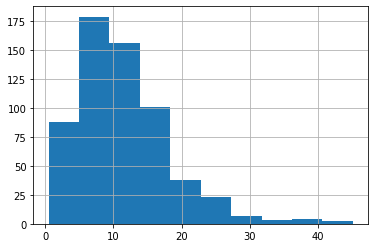

In [ ]:
Data_Essay_01['Connectivity_Index'].hist()

In [ ]:
Data_Essay_01.to_csv("Output_4.csv")
files.download('/content/Output_4.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Readibility Scores**

We section will cover:
1.   Flesch Reading Ease
2.   Flesch-Kincaid Grade Level
3.   Gunning Fog Index
4.   Dale Chall Readability Formula

In [ ]:
#Required Pre-processing for Readability Scores.
Data_Essay_01["Preprocessed_Essay"] = Data_Essay_01["Essay"].apply(Remove_NER2)
Data_Essay_01["Preprocessed_Essay"] = Data_Essay_01["Preprocessed_Essay"].apply(LowerCase_Words)

In [ ]:
Data_Essay_01.head()

,essay_id,essay_set,Essay,domain1_predictionid,domain2_predictionid,Sent_Count,Word_Count,Char_Count,Avg_Word_Count,Avg_Sentence_Length,...,Count_Exclamation,Count_Comma,Count_Questionmark,Count_Hyphens,Capitalization_Errors,Grammar_Error_Count,Grammar_Error_List,Sentences_Tokenized,Semantic_Similarity,Connectivity_Index
2343,13632.0,5.0,"The mood in ""@PERSON1"" by @PERSON1 is loving a...",16632.0,NaN,8,172,837,4.029070,21.500000,...,0,4,0,0,0,0,[],"[The mood in ""@PERSON1"" by @PERSON1 is loving ...",0.404186,16.051023
2344,13633.0,5.0,In the memoir Narciso Rodriguez by Narciso Rod...,16633.0,NaN,12,233,1070,3.854077,19.416667,...,0,13,0,0,0,0,[],[In the memoir Narciso Rodriguez by Narciso Ro...,0.383092,7.092311
2345,13634.0,5.0,"In the memoir Narciso Rodriguez, Narciso tells...",16634.0,NaN,7,111,553,4.171171,15.857143,...,0,2,0,0,1,0,[],"[In the memoir Narciso Rodriguez, Narciso tell...",0.541854,7.350010
2346,13635.0,5.0,The mood of the story is that of the comforts ...,16635.0,NaN,3,42,195,3.809524,14.000000,...,0,0,0,0,0,0,[],[The mood of the story is that of the comforts...,0.368585,1.399075
2347,13636.0,5.0,"In the memoir Narciso Rodriguez, it explains t...",16636.0,NaN,3,66,310,3.863636,22.000000,...,0,2,0,0,0,0,[],"[In the memoir Narciso Rodriguez, it explains ...",0.440048,5.599971


### Flesch Reading Ease Score
    In the Flesch reading-ease test, higher scores indicate material that is easier to read; lower numbers mark passages that are more difficult to read

In [ ]:
def Flesch_Reading_Ease_Score(syllable_Count,NoOfsentences,total_Words):
  return (206.835-1.015*(total_Words/float(NoOfsentences))-84.6*(syllable_Count / float(total_Words)))

In [ ]:
Data_Essay_01['Flesch_Reading_Ease_Score']=Data_Essay_01.apply(lambda row :Flesch_Reading_Ease_Score(row["Syllable_Count"],row["Sent_Count"],row["Word_Count"]),axis=1)

### Flesch-Kincaid Grade
    Used extensively in educational fields.
  
    It can also mean the number of years of education generally required to understand this text, relevant when the formula results in a number greater than 10.
    
    For example, a score of 9.3 means that a ninth grader would be able to read the document.






In [ ]:
def Flesh_Kincaid_Grade(total_Words,total_Sentences,syllable_Count):
   F = float(0.39 * (total_Words / total_Sentences) + 11.8 * (syllable_Count / float(total_Words)) - 15.59)
   return F

In [ ]:
Data_Essay_01['Flesh_Kincaid_Grade']=Data_Essay_01.apply(lambda row :Flesh_Kincaid_Grade(row["Syllable_Count"],row["Sent_Count"],row["Word_Count"]),axis=1)

###[Dale-Chall Readability Score](https://www.kaggle.com/code/fshenbayh/readability)
    Provides a numeric gauge of the comprehension difficulty that readers come upon when reading a text
    For example , if score is 4.9 or lower then text is understood by average 4th grade student or lower.







In [ ]:
#Raw score = 0.1579*(PDW) + 0.0496*(ASL) if the percentage of PDW is less than 5%, otherwise compute
#Raw score = 0.1579*(PDW) + 0.0496*(ASL) + 3.6365  

def Dale_Challl_Readability_Score(word_Count ,difficult_Words,avg_sent_length):
    NOT_DIFFICULT_WORDS = word_Count - difficult_Words
    if(word_Count >0):
      # Percentage of words not on difficult word list

      percent_Not_Difficult_Words = float(NOT_DIFFICULT_WORDS) / float(word_Count) * 100
        # diff_words stores percentage of difficult words
    diff_words = 100 - percent_Not_Difficult_Words
    Dale_Chall_Score = (0.1579 * diff_words) +  (0.0496 * avg_sent_length)
    if diff_words > 5:      
 
        Dale_Chall_Score += 3.6365
         
    return Dale_Chall_Score

In [ ]:
Data_Essay_01['Dale_Challl_Readability_Score']=Data_Essay_01.apply(lambda row :Dale_Challl_Readability_Score(row["Word_Count"],row["Difficult_Word_Count"],row["Avg_Sentence_Length"]),axis=1)

In [ ]:
Data_Essay_01.sample

<bound method NDFrame.sample of       essay_id  essay_set                                              Essay  \
2343   13632.0        5.0  The mood in "@PERSON1" by @PERSON1 is loving a...   
2344   13633.0        5.0  In the memoir Narciso Rodriguez by Narciso Rod...   
2345   13634.0        5.0  In the memoir Narciso Rodriguez, Narciso tells...   
2346   13635.0        5.0  The mood of the story is that of the comforts ...   
2347   13636.0        5.0  In the memoir Narciso Rodriguez, it explains t...   
...        ...        ...                                                ...   
2939   14228.0        5.0  The mood for this memior is Very @CAPS1 becaus...   
2940   14229.0        5.0  The mood created in the memoir is happiness, l...   
2941   14230.0        5.0  The author in the memoir created a warm/gratef...   
2942   14231.0        5.0  In the selection, Narciso Rodriguez written by...   
2943   14232.0        5.0  In this memoir, Narciso Rodriguez, a Cuban clo...   

      d

## **Vocabulary Analysis**

In [ ]:
#REPEATED PROCESSING AS BAWANY SAID EVERYONE GOT TO DO THEIR OWN PROCESSING.
Data_Essay_01["Preprocessed_Essay"] = Data_Essay_01["Essay"].apply(Remove_NER2)
Data_Essay_01["Preprocessed_Essay"] = Data_Essay_01["Preprocessed_Essay"].apply(LowerCase_Words)
Data_Essay_01["Preprocessed_Essay"] = Data_Essay_01["Preprocessed_Essay"].apply(Remove_Punctuations)

### Lexical Diversity ( Ratio of Unique Words to Total Number of Words ) 

```
Execution Time: 5 minutes +
```

In [ ]:
lemmatizer = WordNetLemmatizer()

def Unique_Words_Per_Essay(text):

  token_words = word_tokenize(text)

  #Perform lemma on token_words( since Continous and Continuously are both one uniquen word) and then join them as a sentence.

  unique_words_lemma=[]
  for unique in token_words:
    unique_words_lemma.append(lemmatizer.lemmatize(unique, 'v'))
    unique_words_lemma.append(" ")
  lemma_words= "".join(unique_words_lemma)

  #COUNT ALL UNIQUE WORDS IN LEMMATIZED WORDS
  unique_words = set(lemma_words.split())

  #Neglect all the misspelt words
  correct_unique_words=[]

  for unique in unique_words:
    word = Word(unique)
    result = word.spellcheck()

  # #   # result [0][0] contains the bool value if the spelling is correct or not
  # #   # result [0][1] contains the confidence for the suggest correct spelling

    if word == result[0][0]:
        correct_unique_words.append(word)
  length = len(correct_unique_words)

  return length

def Ratio_Lexical_Diversity(Length_Unique_Words,Word_Count):
    return Length_Unique_Words/Word_Count


In [ ]:
Data_Essay_01["Unique_Words_LD"]=Data_Essay_01["Preprocessed_Essay"].apply(Unique_Words_Per_Essay) #Simple Count
Data_Essay_01["Lexical_Diversity"]=Data_Essay_01.apply(lambda row :Ratio_Lexical_Diversity(row["Unique_Words_LD"],row["Word_Count"]),axis=1) #Ratio


In [ ]:
Data_Essay_01

,essay_id,essay_set,Essay,domain1_predictionid,domain2_predictionid,Sent_Count,Word_Count,Char_Count,Avg_Word_Count,Avg_Sentence_Length,...,Grammar_Error_Count,Grammar_Error_List,Sentences_Tokenized,Semantic_Similarity,Connectivity_Index,Flesch_Reading_Ease_Score,Flesh_Kincaid_Grade,Dale_Challl_Readability_Score,Unique_Words_LD,Lexical_Diversity
2343,13632.0,5.0,"The mood in ""@PERSON1"" by @PERSON1 is loving a...",16632.0,NaN,8,172,837,4.029070,21.500000,...,0,[],"[The mood in ""@PERSON1"" by @PERSON1 is loving ...",0.404186,16.051023,94.018314,4.399561,6.722551,79,0.459302
2344,13633.0,5.0,In the memoir Narciso Rodriguez by Narciso Rod...,16633.0,NaN,12,233,1070,3.854077,19.416667,...,0,[],[In the memoir Narciso Rodriguez by Narciso Ro...,0.383092,7.092311,97.443822,3.568674,6.632614,87,0.373391
2345,13634.0,5.0,"In the memoir Narciso Rodriguez, Narciso tells...",16634.0,NaN,7,111,553,4.171171,15.857143,...,0,[],"[In the memoir Narciso Rodriguez, Narciso tell...",0.541854,7.350010,89.372432,1.668120,6.983555,51,0.459459
2346,13635.0,5.0,The mood of the story is that of the comforts ...,16635.0,NaN,3,42,195,3.809524,14.000000,...,0,[],[The mood of the story is that of the comforts...,0.368585,1.399075,87.882143,0.700769,6.962567,22,0.523810
2347,13636.0,5.0,"In the memoir Narciso Rodriguez, it explains t...",16636.0,NaN,3,66,310,3.863636,22.000000,...,0,[],"[In the memoir Narciso Rodriguez, it explains ...",0.440048,5.599971,87.086818,4.537368,8.077094,37,0.560606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,14228.0,5.0,The mood for this memior is Very @CAPS1 becaus...,17228.0,NaN,4,133,647,4.030075,33.250000,...,0,[],[The mood for this memior is Very @CAPS1 becau...,0.291938,13.354759,82.125348,9.327325,7.303971,61,0.458647
2940,14229.0,5.0,"The mood created in the memoir is happiness, l...",17229.0,NaN,9,254,1214,3.976378,28.222222,...,0,[],"[The mood created in the memoir is happiness, ...",0.334040,18.960830,79.600468,7.362342,7.647267,115,0.452756
2941,14230.0,5.0,The author in the memoir created a warm/gratef...,17230.0,NaN,10,238,1160,4.033613,23.800000,...,0,[],[The author in the memoir created a warm/grate...,0.404741,18.106485,84.570437,5.349362,6.940005,93,0.390756
2942,14231.0,5.0,"In the selection, Narciso Rodriguez written by...",17231.0,NaN,5,127,649,4.212598,25.400000,...,1,[WAY_COMPOUNDS],"[In the selection, Narciso Rodriguez written b...",0.371541,4.436912,74.471323,6.256250,7.880277,63,0.496063


### Lexical Density (Number of content words like POS tags)

In [ ]:
def Lexical_Density_Per_Essay(Verb_Count,Adj_Count,Conj_Count,Noun_Count,Adv_Count,pNoun_Count):
  sum =0
  sum=sum+Verb_Count+Adj_Count+Conj_Count+Noun_Count+Adv_Count+pNoun_Count
  return sum;

In [ ]:
Data_Essay_01["Lexical_Density"]=Data_Essay_01.apply(lambda row :Lexical_Density_Per_Essay(row["Verb_Count"],row["Adj_Count"],row["Conj_Count"],row["Noun_Count"],row["Adverb_Count"],row["pNoun_Count"]),axis=1)


### Lexical originality(# of words unique to a writer divided by total # of words in a corpous of group of writers(essay set))

In [ ]:
def Total_Word_Count():
  return Data_Essay_01['Word_Count'].sum()
     
def Lexical_Originality_Per_Essay(Unique_Words,Total_Words):
    return Unique_Words/Total_Words

In [ ]:
Total = Total_Word_Count()
Data_Essay_01["Lexical_Originality"] = Data_Essay_01.apply(lambda row :Lexical_Originality_Per_Essay(row["Unique_Words_LD"],Total),axis=1)

### Lexical Accuracy (Number of errors) 

In [ ]:
def Lexical_Accuracy(Grammer_Error_Count,Spelling_Error_Count):
    total = Grammer_Error_Count + Spelling_Error_Count
    return total

In [ ]:
Data_Essay_01["Lexical_Accuracy"] = Data_Essay_01.apply(lambda row :Lexical_Accuracy(row["Grammar_Error_Count"],row["Spelling_Mistakes_Count"]),axis=1)

## **Domain Information Content** 
It is perhaps the most marked feature of our model as it tries to understand semantics and information content of an essay. To get this feature working, we first figured out the best essay from each set (highest scored essay) then, we pulled out nouns from that essay. These nouns were served as keywords for the particular domain. Then, we fire these word into 'WordNet' and take out their equivalent. In this way, for each set, we got a bunch of different words, most relevant to its particular domain. Then, we count the number of domain words in the essay provided. 

In [ ]:
temp_df = Data_Essay_01[Data_Essay_01['Total Score'] == max(Data_Essay_01["Total Score"])]
temp_df.head()

,ID,Essay,Rater_1 Score,Rater_2 Score,Total Score
15,16,"Dear @ORGANIZATION1, The computer blinked to l...",6.0,6.0,12.0
36,37,"Dear @ORGANIZATION1, @CAPS1 has been brought t...",6.0,6.0,12.0
69,70,"Dear @CAPS1 @CAPS2, @CAPS3 life without comput...",6.0,6.0,12.0
117,118,"Dear Local Newspaper @CAPS1, @CAPS2 our techno...",6.0,6.0,12.0
146,147,Hour after hour of gaming online and posting b...,6.0,6.0,12.0


In [ ]:
temp_df.count()

ID               47
Essay            47
Rater_1 Score    47
Rater_2 Score    47
Total Score      47
dtype: int64

In [ ]:
temp_df = temp_df.reset_index()
temp_df.drop("index", axis="columns", inplace=True)
temp_df.drop("ID" , axis="columns",inplace=True)

In [ ]:
temp_df.head()

,Essay,Rater_1 Score,Rater_2 Score,Total Score
0,"Dear @ORGANIZATION1, The computer blinked to l...",6.0,6.0,12.0
1,"Dear @ORGANIZATION1, @CAPS1 has been brought t...",6.0,6.0,12.0
2,"Dear @CAPS1 @CAPS2, @CAPS3 life without comput...",6.0,6.0,12.0
3,"Dear Local Newspaper @CAPS1, @CAPS2 our techno...",6.0,6.0,12.0
4,Hour after hour of gaming online and posting b...,6.0,6.0,12.0


In [ ]:
temp_df['Preprocessed_Essay'] = temp_df['Essay'].apply(Remove_NER)
temp_df['Preprocessed_Essay'] = temp_df['Preprocessed_Essay'].apply(Tokenize_Essay)
temp_df.head()

,Essay,Rater_1 Score,Rater_2 Score,Total Score,Preprocessed_Essay
0,"Dear @ORGANIZATION1, The computer blinked to l...",6.0,6.0,12.0,Dear The computer blinked to life and an image...
1,"Dear @ORGANIZATION1, @CAPS1 has been brought t...",6.0,6.0,12.0,Dear has been brought to my attention that som...
2,"Dear @CAPS1 @CAPS2, @CAPS3 life without comput...",6.0,6.0,12.0,Dear life without computers There would be no ...
3,"Dear Local Newspaper @CAPS1, @CAPS2 our techno...",6.0,6.0,12.0,Dear Local Newspaper our technology advance so...
4,Hour after hour of gaming online and posting b...,6.0,6.0,12.0,Hour after hour of gaming online and posting b...


In [ ]:
Nouns_List = []

# Extracting Nouns of Best Essays

def Extract_Nouns(Essay):
  """
    Extract Nouns From an Essay

    Args:
      Essay: Best Essay based on score  
  """
  tagged_doc = nlp(Essay)

  for token in tagged_doc:
    if(token.pos_ =='NOUN'):
      if (not(token in Nouns_List)):
        Nouns_List.append(token)
  return Nouns_List

In [ ]:
temp_df["Nouns_List"] = temp_df['Preprocessed_Essay'].apply(Extract_Nouns)

Now finding synonyms of those nouns

In [ ]:
synonyms = []

def Extract_Synonyms(Nouns_List):
  for word in Nouns_List:
    for syn in wordnet.synsets(str(word)):
        for i in syn.lemmas():
            synonyms.append(i.name())

In [ ]:
Extract_Synonyms(set(Nouns_List))

In [ ]:
Nouns_List.extend(synonyms)

In [ ]:
len(Nouns_List)

110560

In [ ]:
def Finding_Top_Words(Essay):
  count = 0;
  words = nltk.word_tokenize(Essay)
  for word in words:
    if word.lower() in str(Nouns_List):
      count += 1
    else:
      continue

  return count

In [ ]:
# Finding_Top_Words(Data_Essay_01["Essay"][0])
Data_Essay_01['Preprocessed_Essay'] = Data_Essay_01['Essay'].apply(Remove_NER)
Data_Essay_01['Preprocessed_Essay'] = Data_Essay_01['Preprocessed_Essay'].apply(Remove_Punctuations)

In [ ]:
Data_Essay_01['Domain_Info_Count'] = Data_Essay_01['Preprocessed_Essay'].apply(Finding_Top_Words)

In [ ]:
Data_Essay_01.head()

,ID,Essay,Rater_1 Score,Rater_2 Score,Total Score,Preprocessed_Essay,Domain_Info_Count
0,1,"Dear local newspaper, I think effects computer...",4.0,4.0,8.0,Dear local newspaper I think effects computer...,299
1,2,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,9.0,Dear I believe that using computers will ben...,350
2,3,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,7.0,Dear More and more people use computers but ...,240
3,4,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,10.0,Dear Local Newspaper I have found that many e...,384
4,5,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,8.0,Dear I know having computers has a positive ...,387


## **Percentage of Passive Sentences**
    The percentage of passive senteces will tell us what was done or performed during the story written by the student rather than who did it.

In [ ]:
#Perform pre-processing on the raw data (Essay)
Data_Essay_01["Preprocessed_Essay"] = Data_Essay_01["Essay"].apply(Remove_NER2)
Data_Essay_01["Preprocessed_Essay"] = Data_Essay_01["Preprocessed_Essay"].apply(LowerCase_Words)

In [ ]:
def Percentage_Passive_Sent(Essay):
  """
    Calculate the percentage of passive sentences in an essay

    Args:
      Essay: Essay of each student 
    
    Returns: 
      will see
  """
  # tokenize the text into sentences
  sentences = nltk.sent_tokenize(Essay)
  passive_sent_count=0
  active_sent_count=0
  for sentence in sentences:
    tags = nltk.pos_tag(nltk.word_tokenize(sentence))

    # print(tags[1][1])
    if len(tags) >= 2 and  (tags[1][1] == 'VBN' or tags[1][1] == 'VBD' or tags[1][1] == 'VBG'  ):
        passive_sent_count += 1
    else:
        active_sent_count += 1
  total_sentences = passive_sent_count + active_sent_count
  percent_passive = passive_sent_count / total_sentences * 100
  print(f"Percentage of passive sentences: {percent_passive:.2f}%")
  return percent_passive
  # print("\n")

In [ ]:
# text=Data_Essay_01['Preprocessed_Essay'][0]
Data_Essay_01['Percentage_Passive_Sent'] = Data_Essay_01["Preprocessed_Essay"].apply(Percentage_Passive_Sent)


In [ ]:
Data_Essay_01

In [ ]:
Data_Essay_01.to_csv("EssaySet01_Training_Features.csv")
files.download('/content/EssaySet01_Training_Features.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Yule K**
    Yule's K is a measure of lexical diversity in a text, which provides information about the richness and variety of vocabulary used in the text. 
    A higher value of Yule's K indicates a more diverse vocabulary in the text, meaning that there are a larger number of different word types used relatively evenly throughout the text.

In [ ]:
#Perform pre-processing on the raw data (Essay)
Data_Essay_01["Preprocessed_Essay"] = Data_Essay_01["Essay"].apply(Remove_NER2)
Data_Essay_01["Preprocessed_Essay"] = Data_Essay_01["Preprocessed_Essay"].apply(LowerCase_Words)
Data_Essay_01["Preprocessed_Essay"] = Data_Essay_01["Preprocessed_Essay"].apply(Remove_Punctuations)
Data_Essay_01["Preprocessed_Essay"] = Data_Essay_01["Preprocessed_Essay"].apply(Remove_Special_Characters)
Data_Essay_01["Preprocessed_Essay"] = Data_Essay_01["Preprocessed_Essay"].apply(Remove_Special_Characters)


,ID,Essay,Rater_1 Score,Rater_2 Score,Total Score,Preprocessed_Essay
0,1,"Dear local newspaper, I think effects computer...",4.0,4.0,8.0,dear local newspaper i think effects computer...
1,2,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,9.0,dear i believe that using computers will benef...
2,3,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,7.0,dear more and more people use computers but ...
3,4,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,10.0,dear local newspaper i have found that many e...
4,5,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,8.0,dear i know having computers has a positive ef...
...,...,...,...,...,...,...
1778,1783,"Dear @CAPS1, @CAPS2 several reasons on way I t...",4.0,4.0,8.0,dear several reasons on way i that advances in...
1779,1784,Do a adults and kids spend to much time on the...,3.0,4.0,7.0,do a adults and kids spend to much time on the...
1780,1785,My opinion is that people should have computer...,4.0,4.0,8.0,my opinion is that people should have computer...
1781,1786,"Dear readers, I think that its good and bad to...",1.0,1.0,2.0,dear readers i think that its good and bad to...


In [ ]:
def Yule_K(text):
# calculate M1 (total number of types)
  word_freq = {}
  for word in text.split():
      if word in word_freq:
          word_freq[word] += 1
      else:
          word_freq[word] = 1
  M1 = len(word_freq)

  # calculate M2 (total number of words that occur more than once)
  M2 = 0
  for freq in word_freq.values():
      if freq > 1:
          M2 += freq

  # calculate Yule's K
  K = (M2 - M1) / (M2 + M1)

  return K

In [ ]:
Data_Essay_01["Yule_K"]=Data_Essay_01["Preprocessed_Essay"].apply(Yule_K)


## **Term Frequency - Inverse Document Frequency**
Ranking the documents based on similarity with the source document in comprehension based essays

Reading the prompt provided (comprehension)

In [ ]:
f = open("Essay_Set06_Prompt.txt" , "r");
comprehension = f.read();

In [ ]:
vectorizer = TfidfVectorizer()
comprehension_vector = vectorizer.fit_transform([comprehension])

In [ ]:
def Find_Relevance(Essay):
  answer_vector = vectorizer.transform([Essay])

  # Calculate the cosine similarity between the vectors
  similarity = cosine_similarity(comprehension_vector, answer_vector)

  return similarity[0][0]

In [ ]:
Data_Essay_01['Source_Relevance'] = Data_Essay_01['Essay'].apply(Find_Relevance)

## **Saving All The Features in a CSV**

In [ ]:
print(Data_Essay_01.columns)

Index(['essay_id', 'essay_set', 'Essay', 'domain1_predictionid',
       'domain2_predictionid', 'Sent_Count', 'Word_Count', 'Char_Count',
       'Avg_Word_Count', 'Avg_Sentence_Length', 'Preprocessed_Essay',
       'Syllable_Count', 'Difficult_Word_Count', 'Verb_Count', 'Noun_Count',
       'Adj_Count', 'Conj_Count', 'Adverb_Count', 'pNoun_Count',
       'Spelling_Mistakes_Count', 'Without_White_Spaces',
       'Essay_SpellingCorrected_LT', 'Count_Fullstops', 'Count_Exclamation',
       'Count_Comma', 'Count_Questionmark', 'Count_Hyphens',
       'Capitalization_Errors', 'Grammar_Error_Count', 'Grammar_Error_List',
       'Sentences_Tokenized', 'Semantic_Similarity', 'Connectivity_Index',
       'Flesch_Reading_Ease_Score', 'Flesh_Kincaid_Grade',
       'Dale_Challl_Readability_Score', 'Unique_Words_LD', 'Lexical_Diversity',
       'Lexical_Density', 'Lexical_Originality', 'Lexical_Accuracy'],
      dtype='object')


In [ ]:
Data_Essay_01.to_csv("EssaySet06_Training_Features.csv")
files.download('/content/EssaySet01_Training_Features.csv')

# **Features Correlation Visualization**

In [ ]:
# Data_Essay_01_Features = pd.read_csv("/content/drive/MyDrive/IntelliTech-DataSet/EssaySet01_Features.csv")
Data_Essay_01_Features = pd.read_csv("EssaySet01_Features.csv");
Data_Essay_01_Features.head()

,Unnamed: 0,ID,Essay,Rater_1 Score,Rater_2 Score,Total Score,Sent_Count,Word_Count,Char_Count,Avg_Word_Count,...,Connectivity_Index,Flesch_Reading_Ease_Score,Flesh_Kincaid_Grade,Dale_Challl_Readability_Score,Unique_Words_LD,Lexical_Diversity,Lexical_Density,Lexical_Originality,Lexical_Accuracy,Domain_Info_Count
0,0,1,"Dear local newspaper, I think effects computer...",4,4,8,16,386,1875,3.984456,...,24.552787,86.789576,5.484289,6.551183,143,0.370466,224,0.000192,8,299
1,1,2,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,9,20,464,2288,4.030172,...,25.344232,79.907259,5.122937,6.726940,159,0.342672,273,0.000214,11,350
2,2,3,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,7,14,313,1541,4.035144,...,14.662850,80.081797,4.728247,7.015542,131,0.418530,180,0.000176,8,240
3,3,4,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,10,27,611,3165,4.328969,...,32.408323,84.865926,4.821414,7.214003,184,0.301146,306,0.000247,18,384
4,4,5,"Dear @LOCATION1, I know having computers has a...",4,4,8,30,517,2569,4.071567,...,27.824804,81.834076,2.236540,6.354310,168,0.324952,288,0.000226,15,387


In [ ]:
Data_Essay_01_Features.columns

Index(['Unnamed: 0', 'ID', 'Essay', 'Rater_1 Score', 'Rater_2 Score',
       'Total Score', 'Sent_Count', 'Word_Count', 'Char_Count',
       'Avg_Word_Count', 'Avg_Sentence_Length', 'Preprocessed_Essay',
       'Syllable_Count', 'Difficult_Word_Count', 'Verb_Count', 'Noun_Count',
       'Adj_Count', 'Conj_Count', 'Adverb_Count', 'pNoun_Count',
       'Spelling_Mistakes_Count', 'Without_White_Spaces',
       'Essay_SpellingCorrected_LT', 'Count_Fullstops', 'Count_Exclamation',
       'Count_Comma', 'Count_Questionmark', 'Count_Hyphens',
       'Capitalization_Errors', 'Grammar_Error_Count', 'Grammar_Error_List',
       'Sentences_Tokenized', 'Semantic_Similarity', 'Connectivity_Index',
       'Flesch_Reading_Ease_Score', 'Flesh_Kincaid_Grade',
       'Dale_Challl_Readability_Score', 'Unique_Words_LD', 'Lexical_Diversity',
       'Lexical_Density', 'Lexical_Originality', 'Lexical_Accuracy',
       'Domain_Info_Count'],
      dtype='object')

In [ ]:
Data_Essay_01_Features.drop('Unnamed: 0' , axis = 1 , inplace = True)

In [ ]:
Data_Essay_01_Features.corr()

,ID,Rater_1 Score,Rater_2 Score,Total Score,Sent_Count,Word_Count,Char_Count,Avg_Word_Count,Avg_Sentence_Length,Syllable_Count,...,Connectivity_Index,Flesch_Reading_Ease_Score,Flesh_Kincaid_Grade,Dale_Challl_Readability_Score,Unique_Words_LD,Lexical_Diversity,Lexical_Density,Lexical_Originality,Lexical_Accuracy,Domain_Info_Count
ID,1.000000,-0.003870,0.020841,0.008939,0.000586,-0.002075,-0.002165,-0.008777,-0.023707,-0.004772,...,0.007803,0.029752,-0.025030,-0.027156,0.004194,0.005726,-0.001893,0.004191,-0.002789,-0.004778
Rater_1 Score,-0.003870,1.000000,0.721327,0.930041,0.636066,0.745831,0.755459,0.168524,-0.125335,0.745544,...,0.302647,0.097449,-0.124500,0.040968,0.762679,-0.425159,0.725601,0.762676,0.255012,0.716940
Rater_2 Score,0.020841,0.721327,1.000000,0.925362,0.650265,0.753142,0.762079,0.155869,-0.149800,0.752896,...,0.325432,0.121170,-0.150415,0.028783,0.772024,-0.434148,0.729301,0.772024,0.263641,0.723140
Total Score,0.008939,0.930041,0.925362,1.000000,0.693143,0.807803,0.817815,0.174937,-0.148078,0.807516,...,0.338309,0.117625,-0.147946,0.037694,0.827043,-0.463044,0.784082,0.827041,0.279453,0.776073
Sent_Count,0.000586,0.636066,0.650265,0.693143,1.000000,0.822060,0.806679,0.017532,-0.482120,0.799274,...,0.091705,0.426057,-0.466537,-0.263122,0.773867,-0.483244,0.798714,0.773867,0.291319,0.796859
Word_Count,-0.002075,0.745831,0.753142,0.807803,0.822060,1.000000,0.990724,0.045246,-0.105845,0.974460,...,0.451947,0.152123,-0.103547,-0.080283,0.911714,-0.617821,0.976575,0.911713,0.385851,0.976965
Char_Count,-0.002165,0.755459,0.762079,0.817815,0.806679,0.990724,1.000000,0.169984,-0.102373,0.990048,...,0.448923,0.079603,-0.102268,-0.012604,0.921146,-0.585164,0.973665,0.921146,0.380296,0.968401
Avg_Word_Count,-0.008777,0.168524,0.155869,0.174937,0.017532,0.045246,0.169984,1.000000,-0.045971,0.201379,...,-0.029033,-0.469805,-0.057208,0.517845,0.169585,0.205437,0.071012,0.169587,-0.011420,0.022591
Avg_Sentence_Length,-0.023707,-0.125335,-0.149800,-0.148078,-0.482120,-0.105845,-0.102373,-0.045971,1.000000,-0.107997,...,0.406738,-0.743850,0.995328,0.496939,-0.143646,-0.015475,-0.094442,-0.143650,0.019140,-0.088646
Syllable_Count,-0.004772,0.745544,0.752896,0.807516,0.799274,0.974460,0.990048,0.201379,-0.107997,1.000000,...,0.458785,0.012626,-0.110328,0.010652,0.917711,-0.565861,0.975258,0.917710,0.377839,0.972383


In [ ]:
import seaborn as sns

# Plot correlation of essay-length related features
cols = ['Sent_Count', 'Word_Count', 'Char_Count']
#        'Avg_Word_Count',
#        'Verb_Count', 'Noun_Count', 'Adj_Count', 'Conj_Count', 'Adverb_Count',
#        'pNoun_Count', 'Count_Fullstops', 'Count_Exclamation', 'Count_Comma',
#        'Count_Questionmark', 'Count_Hyphens', 'Capitalization_Errors',
#        'Grammar_Error_Count', 'Punctuation_Errors']
        
g = sns.pairplot(Data_Essay_01_Features, hue='Target_Score', vars=cols, plot_kws={"s": 20}, palette="bright")
g.fig.subplots_adjust(top=.93)
g.fig.suptitle('Pairplots of select features', fontsize=16)
plt.show()